<a href="https://colab.research.google.com/github/sagawritescode/ENDTwoPointOPhase1/blob/main/ERA_V1_Assignment_8_Layer_Normalisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [19]:
%matplotlib inline

In [20]:
import torch
import torchvision
import torchvision.transforms as transforms

Data Download and Transformations

In [21]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Inspect the dataset

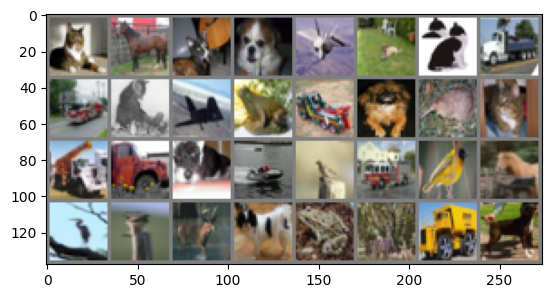

cat   horse cat   dog   plane dog   cat   truck truck cat   plane frog  truck dog   bird  cat   truck truck dog   ship  bird  truck bird  horse bird  bird  deer  dog   frog  deer  truck dog  


In [22]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Model Initialisation and Summary

In [23]:
!pip install torchsummary
from torchsummary import summary
from model import LayerNormalisationModel
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = LayerNormalisationModel().to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 34, 34]             512
        MaxPool2d-10           [-1, 16, 17, 17]               0
           Conv2d-11           [-1, 16, 17, 17]           2,304
             ReLU-12           [-1, 16, 17, 17]               0

Define Train and Test Functions

In [24]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassified_images = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    iterator_count = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_comparisons = pred.eq(target.view_as(pred))
            correct += pred_comparisons.sum().item()

            ## code to store misclassfied images
            predictions = pred_comparisons.squeeze()
            pred = pred.squeeze()
            target = (target.view_as(pred)).squeeze()
            index = 0
            if len(misclassified_images) < 10:
                for prediction in predictions:
                    if prediction.item() is False:

                        misclassified_images.append((data[index], pred[index].item(), target[index].item()))
                        break
                    index += 1

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

Learning (And Simultaneous Evaluation) Begins!

In [25]:
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.433364987373352 Batch_id=1562 Accuracy=34.19: 100%|██████████| 1563/1563 [00:23<00:00, 67.43it/s]



Test set: Average loss: 1.5164, Accuracy: 4347/10000 (43.47%)

EPOCH: 1


Loss=1.461054801940918 Batch_id=1562 Accuracy=47.30: 100%|██████████| 1563/1563 [00:21<00:00, 74.27it/s]



Test set: Average loss: 1.3737, Accuracy: 5035/10000 (50.35%)

EPOCH: 2


Loss=1.293308138847351 Batch_id=1562 Accuracy=54.89: 100%|██████████| 1563/1563 [00:19<00:00, 81.94it/s]



Test set: Average loss: 1.1534, Accuracy: 5788/10000 (57.88%)

EPOCH: 3


Loss=0.6545040011405945 Batch_id=1562 Accuracy=59.86: 100%|██████████| 1563/1563 [00:19<00:00, 80.67it/s]



Test set: Average loss: 1.1187, Accuracy: 5984/10000 (59.84%)

EPOCH: 4


Loss=0.9714558720588684 Batch_id=1562 Accuracy=63.27: 100%|██████████| 1563/1563 [00:19<00:00, 81.60it/s]



Test set: Average loss: 1.0292, Accuracy: 6267/10000 (62.67%)

EPOCH: 5


Loss=1.0274569988250732 Batch_id=1562 Accuracy=65.41: 100%|██████████| 1563/1563 [00:19<00:00, 80.06it/s]



Test set: Average loss: 0.9043, Accuracy: 6711/10000 (67.11%)

EPOCH: 6


Loss=0.4312770962715149 Batch_id=1562 Accuracy=70.24: 100%|██████████| 1563/1563 [00:19<00:00, 81.97it/s]



Test set: Average loss: 0.8272, Accuracy: 7048/10000 (70.48%)

EPOCH: 7


Loss=0.4378368854522705 Batch_id=1562 Accuracy=71.22: 100%|██████████| 1563/1563 [00:18<00:00, 85.29it/s]



Test set: Average loss: 0.8185, Accuracy: 7072/10000 (70.72%)

EPOCH: 8


Loss=0.5671560168266296 Batch_id=1562 Accuracy=71.66: 100%|██████████| 1563/1563 [00:18<00:00, 82.96it/s]



Test set: Average loss: 0.8125, Accuracy: 7069/10000 (70.69%)

EPOCH: 9


Loss=0.5541814565658569 Batch_id=1562 Accuracy=71.96: 100%|██████████| 1563/1563 [00:18<00:00, 82.63it/s]



Test set: Average loss: 0.8003, Accuracy: 7149/10000 (71.49%)

EPOCH: 10


Loss=1.141996145248413 Batch_id=1562 Accuracy=72.26: 100%|██████████| 1563/1563 [00:19<00:00, 80.18it/s]



Test set: Average loss: 0.8253, Accuracy: 7026/10000 (70.26%)

EPOCH: 11


Loss=0.5932027697563171 Batch_id=1562 Accuracy=72.48: 100%|██████████| 1563/1563 [00:19<00:00, 81.89it/s]



Test set: Average loss: 0.8093, Accuracy: 7100/10000 (71.00%)

EPOCH: 12


Loss=0.7844440340995789 Batch_id=1562 Accuracy=73.20: 100%|██████████| 1563/1563 [00:19<00:00, 82.13it/s]



Test set: Average loss: 0.7872, Accuracy: 7177/10000 (71.77%)

EPOCH: 13


Loss=0.5122380256652832 Batch_id=1562 Accuracy=73.31: 100%|██████████| 1563/1563 [00:19<00:00, 80.93it/s]



Test set: Average loss: 0.7834, Accuracy: 7213/10000 (72.13%)

EPOCH: 14


Loss=0.6258911490440369 Batch_id=1562 Accuracy=73.49: 100%|██████████| 1563/1563 [00:19<00:00, 81.41it/s]



Test set: Average loss: 0.7797, Accuracy: 7214/10000 (72.14%)



Display misclassified images

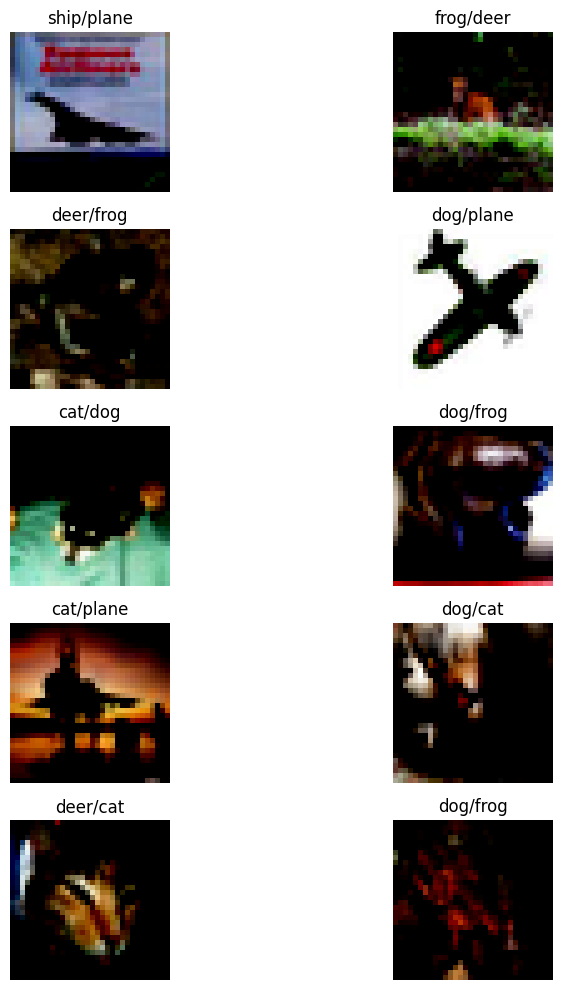

In [26]:
def denormalise_image(normalized_image):
    denormalize = transforms.Normalize((-1, -1, -1), (2, 2, 2))

    # Denormalize the image
    denormalized_image = denormalize(normalized_image)

    # Convert the tensor to a numpy array
    denormalized_image = denormalized_image.cpu().numpy()

    # Convert the image from range [-1, 1] to [0, 1]
    denormalized_image = (denormalized_image + 1) / 2

    return denormalized_image

denormalised_images = []
for image, pred, target in misclassified_images:
    denormalised_images.append((denormalise_image(image), pred, target))


fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for i in range(5):
    for j in range(2):
        misclassified_image = misclassified_images[i * 2 + j]
        image = misclassified_image[0].cpu().numpy()
        axes[i, j].imshow(np.transpose(image, (1, 2, 0)))
        axes[i, j].axis('off')

        axes[i, j].set_title(f'{classes[misclassified_image[1]]}/{classes[misclassified_image[2]]}')
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

<class 'numpy.ndarray'>


Text(0.5, 1.0, 'Test Accuracy')

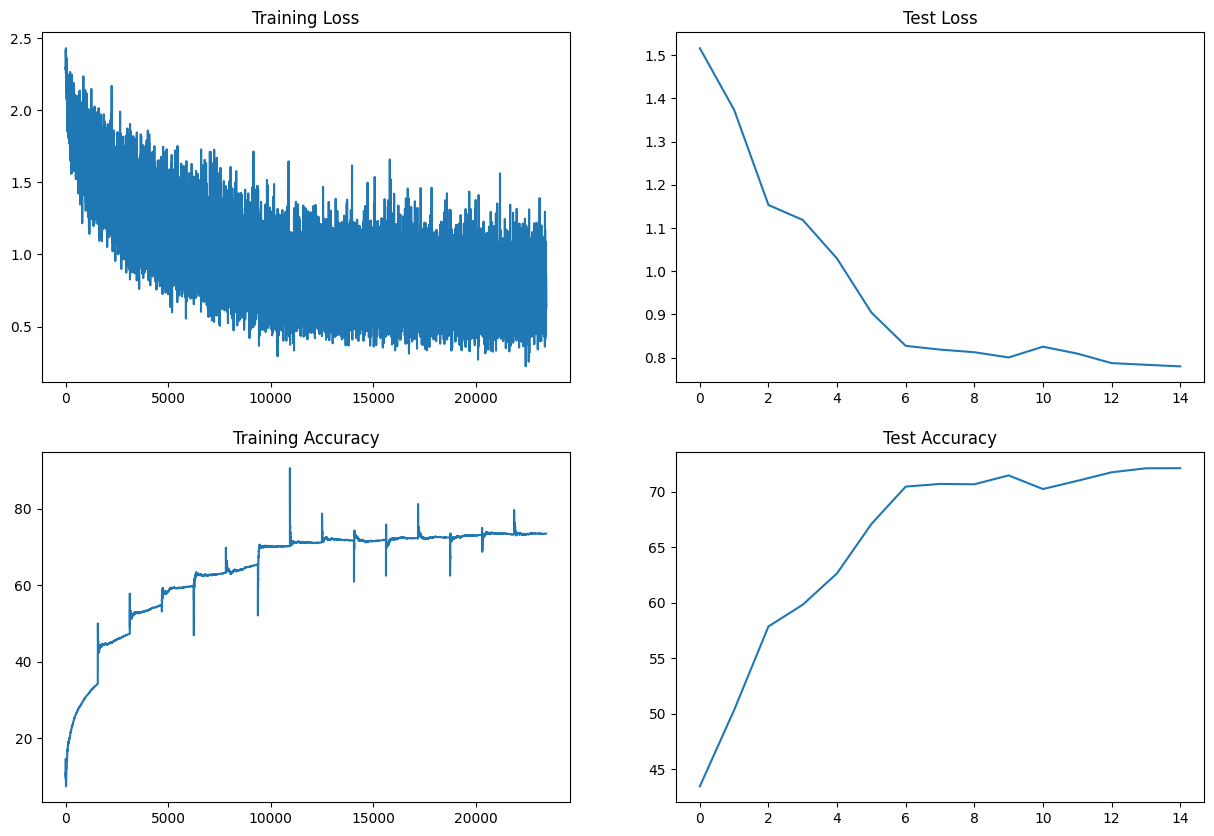

In [27]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
print(type(axs))
t = [t_items.item() for t_items in train_losses]
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")